# settings

## install

In [ ]:
# !pip install catboost optuna

## imports

In [ ]:
import os
import random
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN

from sklearn.decomposition import PCA, KernelPCA

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, BorderlineSMOTE, KMeansSMOTE

import librosa
import librosa.display
import IPython.display as ipd

import tensorflow as tf
import torch

from tensorflow.keras import models, layers, optimizers, callbacks
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

import xgboost as xgb
import lightgbm as lgbm
# import catboost as cat
# import optuna

In [ ]:
# 경로 설정

os.chdir('/content/drive/MyDrive/Colab Notebooks/aichallenge')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/aichallenge'

## GPU

In [ ]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU not found')
    pass
else:
    print(f'GPU found at: {device_name}')

GPU not found


## functions

In [ ]:
def fix_random_seed(random_seed):
    """랜덤시드 고정"""
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print('### random_seed fixed ###\n')


def drop_from_origin(origin_df_in, target_df_in, target_cols):
    #// DataFrame) origin_df_in: 원본 데이터프레임
    #// DataFrame) target_df_in: 원본에서 뺄 데이터프레임
    #// list) target_cols: 중복 검사할 column들
    #// 리턴: origin에서 target을 뺀 여집합

    #// origin과 target은 column 리스트가 일치해야 함
    
    origin_df = origin_df_in.copy()
    target_df = target_df_in.copy()
    
    origin_concat_target = pd.concat([origin_df, target_df], axis=0)
    ret = origin_concat_target.drop_duplicates(subset=target_cols, keep=False)
    ret.reset_index(drop=True, inplace=True)
    
    return ret


def get_gt_from_origin(origin_df_in, target_df_in, target_cols, label_col, id_col):
    #// DataFrame) origin_df_in: 원본 데이터프레임              (column: [label, target_cols])
    #// DataFrame) target_df_in: 원본에서 gt를 찾을 데이터프레임 (column: [id, target_cols])
    #// list) target_cols: 중복 검사할 column들            (X값이 될 column 리스트)
    #// X값은 전부 numeric
    #// string) label_col: y값 column명
    #// string) id_col: id값 column명
    #// returns: DataFrame) 원본에서 X값이 중복인 row들의 id, X, ground truth

    origin_df = origin_df_in.copy()
    target_df = target_df_in.copy()
    origin_df = origin_df.drop_duplicates(subset=target_cols)
    
    origin_concat_target = pd.concat([origin_df, target_df], axis=0)
    origin_concat_target.reset_index(drop=True, inplace=True)
    
    flags = origin_concat_target.duplicated(subset=target_cols, keep=False)
    flags = pd.DataFrame(flags, columns=['dupl'])
    origin_concat_target = pd.concat([origin_concat_target, flags],axis=1)
    
    with_gt_id = origin_concat_target[origin_concat_target['dupl']==True]
    with_gt_id.reset_index(drop=True, inplace=True)
    
    print(with_gt_id.shape)
    cut = len(with_gt_id) / 2

    with_gt = with_gt_id.iloc[:int(cut),:]
    with_id = with_gt_id.iloc[int(cut):,:]

    if len(with_gt) != len(with_id): 
        print("length error")
        return 0
    
    with_gt['std'] = with_gt[target_cols].std(axis=1)
    with_id['std'] = with_id[target_cols].std(axis=1)

    if with_gt['std'].nunique() != with_id['std'].nunique(): 
        print("uniqueness error")
        return 0
    
    with_gt = with_gt.sort_values(by=with_gt.columns[-1])
    with_id = with_id.sort_values(by=with_id.columns[-1])
    
    with_gt.reset_index(drop=True, inplace=True)
    with_id.reset_index(drop=True, inplace=True)
    
    with_id[label_col] = with_gt[label_col]
    
    with_id = with_id.drop(['dupl', 'std'], axis=1)

    id = with_id[id_col]
    X_dupl = with_id[target_cols]
    gt = with_id[label_col] 
    ret = pd.concat([id, X_dupl, gt], axis=1)
    ret.reset_index(drop=True, inplace=True)
    return ret


def inverse_spectral_density(in_df, hz_cols, label_col):
    """푸리에 변환된 spectral density를 역으로 wave 데이터로 변환"""
    #// hz_cols: 주파수 column 이름 리스트  (X값)
    #// label_col: 클래스 column 이름       (y값)
    #// in_df: 원본 pandas dataframe

    spectral_df = in_df.copy()
    
    spectral_df_freq = spectral_df[hz_cols]
    spectral_df_label = spectral_df[label_col]
    
    freq_array = [int(re.sub(r'[^0-9]', '', x)) for x in spectral_df_freq.columns]
    freq_array = np.array(freq_array)
    
    ret = []
    t = []
    for i in range(len(spectral_df)):
        amplitude = spectral_df_freq.iloc[i].values
        Zxx = np.array([freq_array, amplitude]).T
        t, x = signal.istft(Zxx)
        ret.append(x)
    ret = np.asarray(ret)
    ret = pd.DataFrame(ret, columns=t)
    
    return ret, spectral_df_label

## read / sort / split

In [ ]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
sub = pd.read_csv('./data/sample_submission.csv')
aihub = pd.read_csv('./data/aihub.csv')

cols = [x for x in train.columns if 'HZ' in x]
cols_hz = [int(x[:-2]) for x in cols]

# aihub 데이터에서 test 데이터의 레이블 찾아서 dataframe으로 반환
public = get_gt_from_origin(aihub, test, cols, 'leaktype', 'id')

print('### check shape ###')
train.shape, test.shape, sub.shape, aihub.shape, public.shape

(15640, 541)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### check shape ###


((33600, 514), (7820, 514), (7820, 2), (78204, 539), (7820, 515))

In [ ]:
# submission과 test의 input data 순서 동일하게 맞춰 줌

sorter = list(sub['id'])

test.set_index('id', inplace=True)
public.set_index('id', inplace=True)

test = test.loc[sorter].reset_index()
public = public.loc[sorter].reset_index()

print('### check sorted ###\n')
print(f'sub:  {sub["id"].values[:5]}')
print(f'test: {test["id"].values[:5]}')
print(f'public:  {public["id"].values[:5]}')

### check sorted ###

sub:  ['gAbuQeZQCm' '4xtuwcJQI7' '2LgOPmQb8u' 'b6zEYLjs7Y' 'yaYY68O0xX']
test: ['gAbuQeZQCm' '4xtuwcJQI7' '2LgOPmQb8u' 'b6zEYLjs7Y' 'yaYY68O0xX']
public:  ['gAbuQeZQCm' '4xtuwcJQI7' '2LgOPmQb8u' 'b6zEYLjs7Y' 'yaYY68O0xX']


In [ ]:
X_train = train[cols]
y_train = train['leaktype']

X_test = test[cols]
y_test = public['leaktype']

print('### check shape ###')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

### check shape ###


((33600, 513), (33600,), (7820, 513), (7820,))

## config

In [ ]:
# 랜덤시드 고정
seed = 42
fix_random_seed(random_seed=seed)

# encdoer / decoder
encoder = {'out': 0, 'in': 1, 'normal': 2, 'noise': 3, 'other': 4}
decoder = {v: k for k, v in encoder.items()}

# aihub 데이터 비율
aihub_ratio = {'out': 0, 'in': 1, 'normal': 2, 'noise': 3, 'other': 4}

# lgbm params
early_stopping_rounds = 50
lgbm_params = {'n_estimators': 500, 'learning_rate': 0.1, 'feature_fraction': 0.5, 
               'bagging_fraction': 0.67, 'bagging_freq': 1, 'verbose': 0, 
               'n_jobs': 6, 'random_state': seed, 'num_class': 5}

# DL params
optimizer = optimizers.Adamax()
loss = 'categorical_crossentropy'
batch_size = 128
epochs = 50
validation_split = 0.1
es = callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)

### random_seed fixed ###



# EDA

## balance

In [ ]:
train_ratio = train['leaktype'].value_counts().sort_index()
train_ratio / train.shape[0] * 100

in         5.357143
noise     14.880952
normal    53.571429
other     20.833333
out        5.357143
Name: leaktype, dtype: float64

In [ ]:
aihub_ratio = aihub['leaktype'].value_counts().sort_index()
aihub_ratio / aihub.shape[0] * 100

in        21.215027
noise      8.039231
normal    31.491995
other     11.220654
out       28.033093
Name: leaktype, dtype: float64

In [ ]:
public_ratio = public['leaktype'].value_counts().sort_index()
public_ratio / public.shape[0] * 100

in        21.214834
noise      8.043478
normal    31.483376
other     11.227621
out       28.030691
Name: leaktype, dtype: float64

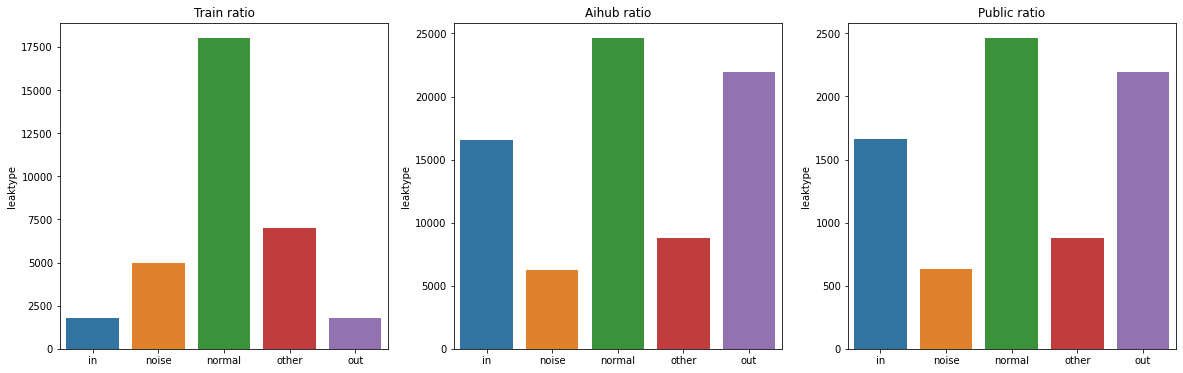

In [ ]:
fig = plt.figure(figsize=(20, 6))

fig.add_subplot(131)
sns.barplot(x=train_ratio.index, y=train_ratio)
plt.title('Train ratio')

fig.add_subplot(132)
sns.barplot(x=aihub_ratio.index, y=aihub_ratio)
plt.title('Aihub ratio')

fig.add_subplot(133)
sns.barplot(x=public_ratio.index, y=public_ratio)
plt.title('Public ratio')
plt.show()

## grouped

In [ ]:
train_grouped = train.groupby('leaktype').mean()[cols].T
aihub_grouped = aihub.groupby('leaktype').mean()[cols].T
public_grouped = public.groupby('leaktype').mean()[cols].T

train_grouped.index = cols_hz
aihub_grouped.index = cols_hz
public_grouped.index = cols_hz

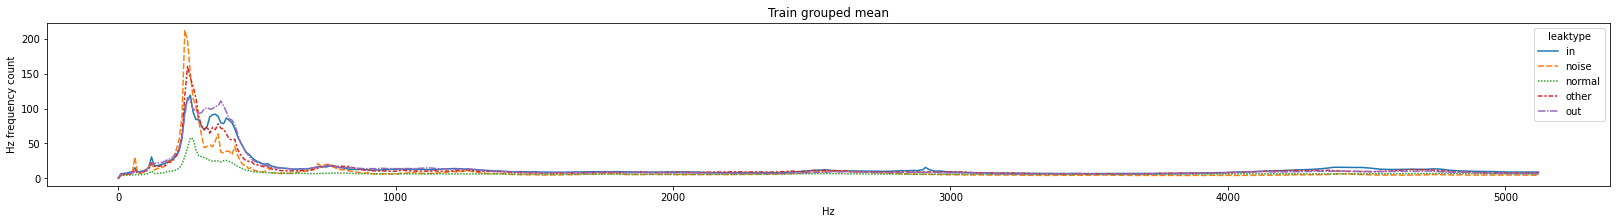

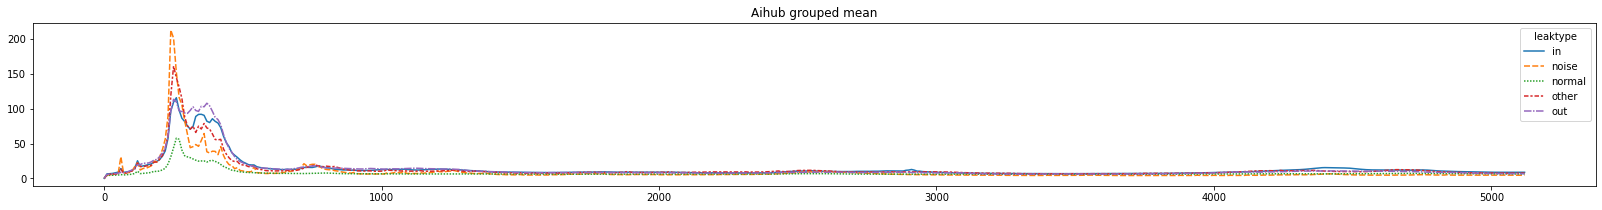

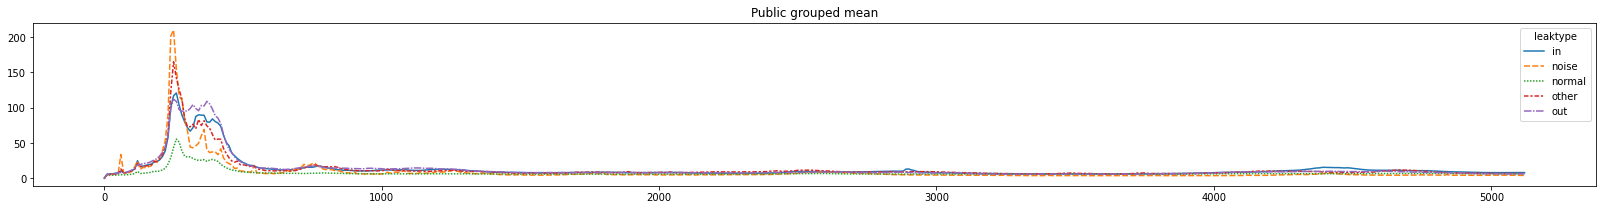

In [ ]:
fs = (28, 3)
plt.figure(figsize=fs)
sns.lineplot(data=train_grouped)
plt.title('Train grouped mean')
plt.xlabel('Hz')
plt.ylabel('Hz frequency count')
plt.show()

plt.figure(figsize=fs)
sns.lineplot(data=aihub_grouped)
plt.title('Aihub grouped mean')
plt.show()

plt.figure(figsize=fs)
sns.lineplot(data=public_grouped)
plt.title('Public grouped mean')
plt.show()

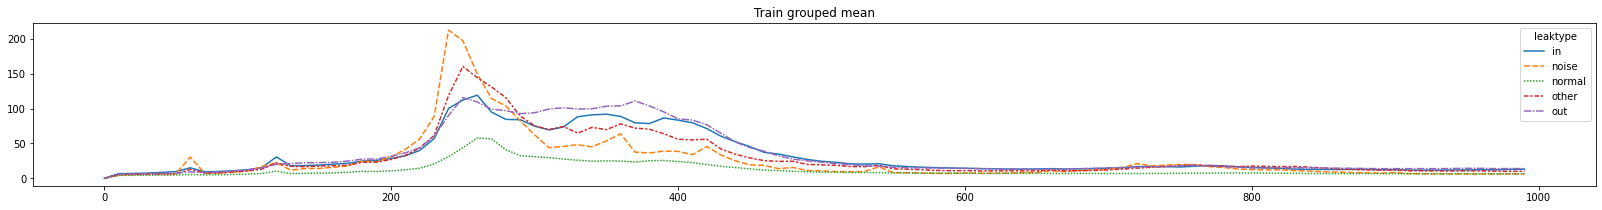

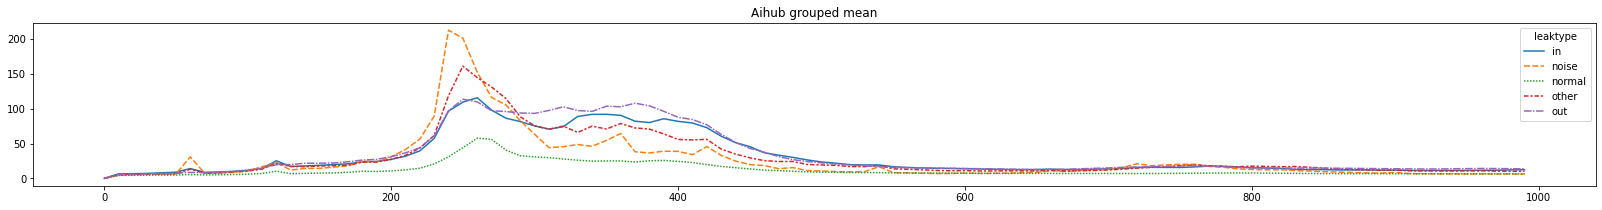

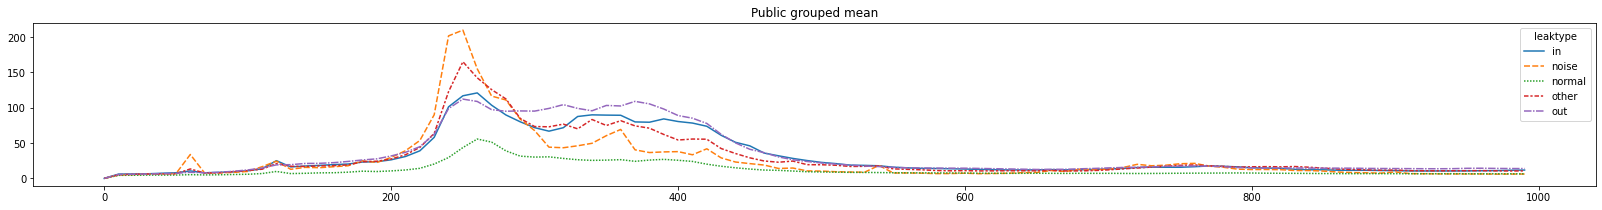

In [ ]:
plt.figure(figsize=fs)
sns.lineplot(data=train_grouped[:100])
plt.title('Train grouped mean')
plt.show()

plt.figure(figsize=fs)
sns.lineplot(data=aihub_grouped[:100])
plt.title('Aihub grouped mean')
plt.show()

plt.figure(figsize=fs)
sns.lineplot(data=public_grouped[:100])
plt.title('Public grouped mean')
plt.show()

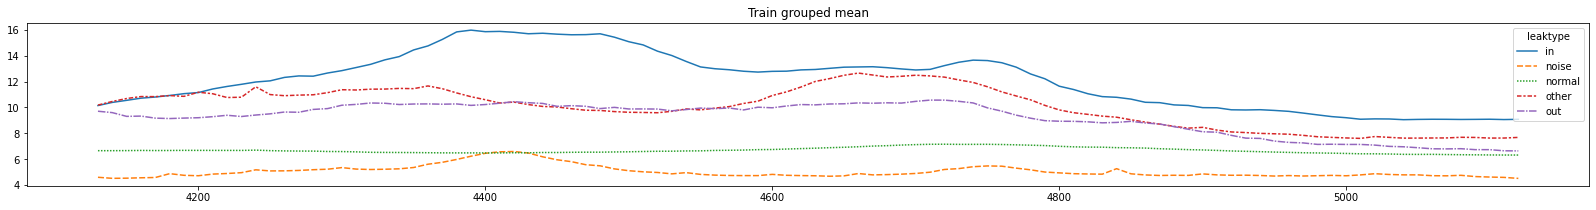

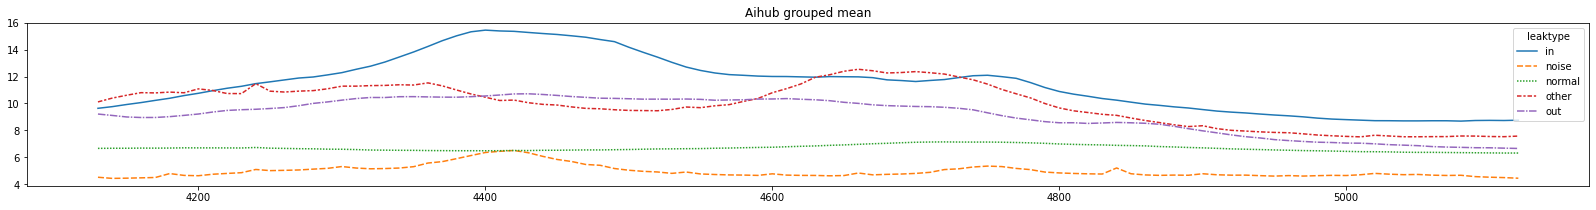

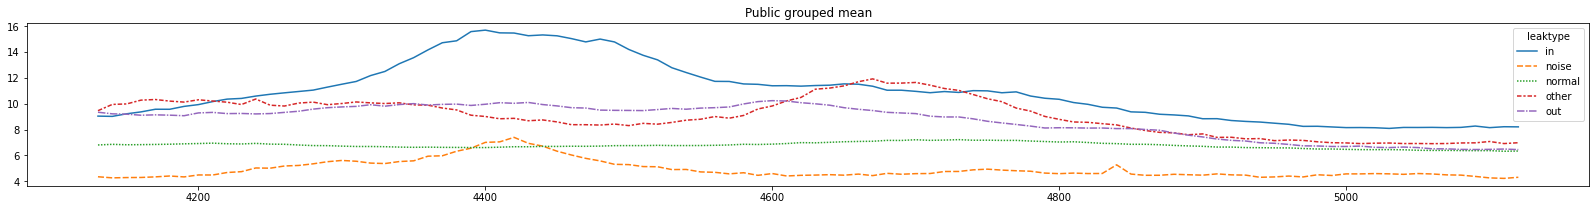

In [ ]:
plt.figure(figsize=fs)
sns.lineplot(data=train_grouped[-100:])
plt.title('Train grouped mean')
plt.show()

plt.figure(figsize=fs)
sns.lineplot(data=aihub_grouped[-100:])
plt.title('Aihub grouped mean')
plt.show()

plt.figure(figsize=fs)
sns.lineplot(data=public_grouped[-100:])
plt.title('Public grouped mean')
plt.show()

## derivatives

In [ ]:
derivatives_aihub = pd.DataFrame({
    'label': aihub['leaktype'],
    'mean': aihub[cols].mean(axis=1),
    'std': aihub[cols].std(axis=1),
    'med': aihub[cols].median(axis=1),
    'max': aihub[cols].max(axis=1),
    'skew': aihub[cols].skew(axis=1),
    'kurt': aihub[cols].kurt(axis=1),
})

derivatives_train = pd.DataFrame({
    'label': train['leaktype'],
    'mean': train[cols].mean(axis=1),
    'std': train[cols].std(axis=1),
    'med': train[cols].median(axis=1),
    'max': train[cols].max(axis=1),
    'skew': train[cols].skew(axis=1),
    'kurt': train[cols].kurt(axis=1),
})

derivatives_public = pd.DataFrame({
    'label': public['leaktype'],
    'mean': public[cols].mean(axis=1),
    'std': public[cols].std(axis=1),
    'med': public[cols].median(axis=1),
    'max': public[cols].max(axis=1),
    'skew': public[cols].skew(axis=1),
    'kurt': public[cols].kurt(axis=1),
})

In [ ]:
derivatives_aihub

,label,mean,std,med,max,skew,kurt
0,out,10.052632,40.641285,3.0,640,11.752124,158.363023
1,out,7.434698,15.508948,6.0,246,12.190526,164.867234
2,out,16.473684,44.266679,9.0,757,12.098459,176.964926
3,out,16.352827,43.794958,8.0,715,11.839646,164.987371
4,out,15.621832,44.783128,9.0,783,12.684254,192.317324
...,...,...,...,...,...,...,...
78199,normal,6.688109,9.232680,5.0,140,10.718998,128.544299
78200,normal,6.974659,8.233016,6.0,112,10.172304,112.355882
78201,normal,11.239766,16.077298,8.0,212,8.543139,84.180752
78202,normal,12.873294,15.725102,10.0,213,9.351407,102.733270


In [ ]:
derivatives_train

,label,mean,std,med,max,skew,kurt
0,out,6.723197,32.062826,2.0,584,13.950853,224.620348
1,out,8.984405,44.264516,3.0,776,12.621837,193.616936
2,out,10.327485,19.747477,6.0,263,6.939141,65.267069
3,out,13.265107,20.465765,6.0,151,3.905980,17.809741
4,out,7.970760,37.027876,3.0,672,13.820979,223.780465
...,...,...,...,...,...,...,...
33595,noise,11.456140,21.934796,6.0,236,6.899373,56.281685
33596,noise,6.791423,23.122917,3.0,442,14.511006,253.297554
33597,noise,5.218324,39.554392,0.0,838,18.696968,386.960450
33598,noise,30.489279,48.262187,14.0,348,3.918891,17.122888


In [ ]:
derivatives_public

,label,mean,std,med,max,skew,kurt
0,normal,14.329435,17.063148,7.0,110,2.491370,6.274549
1,out,7.955166,27.324438,4.0,509,13.624612,229.072161
2,normal,5.996101,5.201786,5.0,116,18.809926,393.115959
3,out,9.662768,27.612436,4.0,341,7.611092,68.487936
4,normal,6.846004,7.614085,6.0,110,9.833823,109.880953
...,...,...,...,...,...,...,...
7815,out,10.801170,52.044109,4.0,1050,16.513012,316.366173
7816,out,27.750487,19.440919,21.0,199,4.694676,31.180212
7817,noise,11.721248,43.968986,3.0,677,10.604257,133.479036
7818,in,8.610136,14.565720,6.0,202,8.778051,92.058678


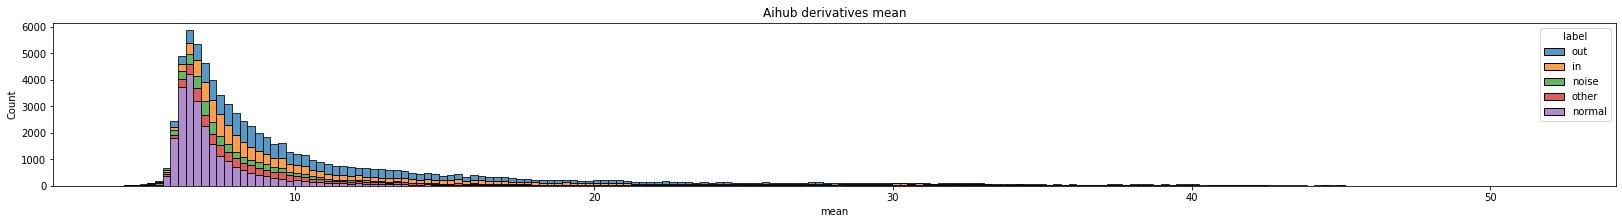

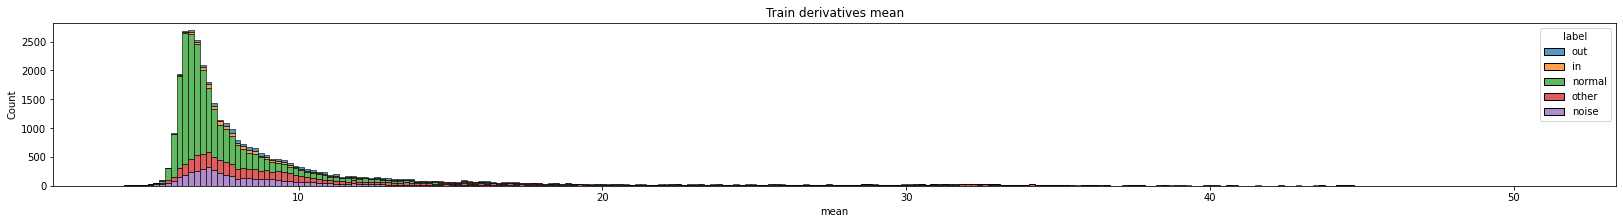

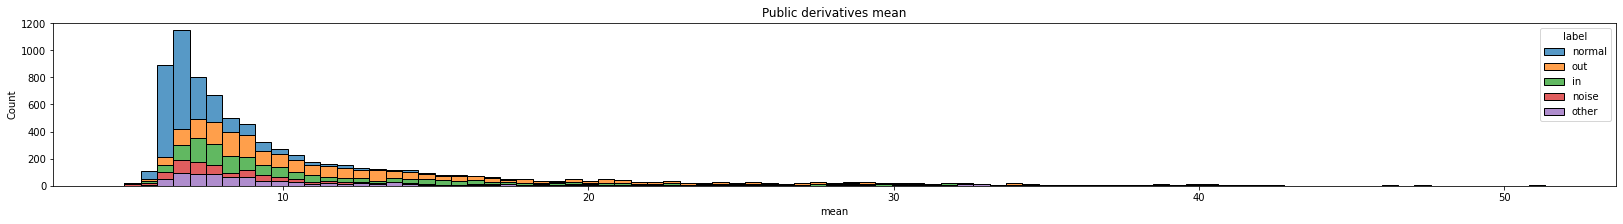

In [ ]:
plt.figure(figsize=fs)
sns.histplot(data=derivatives_aihub, x='mean', hue='label', multiple='stack')
plt.title('Aihub derivatives mean')
plt.show()

plt.figure(figsize=fs)
sns.histplot(data=derivatives_train, x='mean', hue='label', multiple='stack')
plt.title('Train derivatives mean')
plt.show()

plt.figure(figsize=fs)
sns.histplot(data=derivatives_public, x='mean', hue='label', multiple='stack')
plt.title('Public derivatives mean')
plt.show()

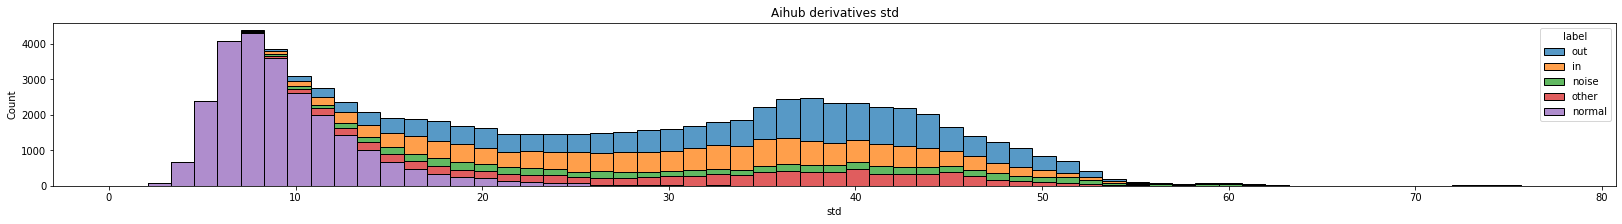

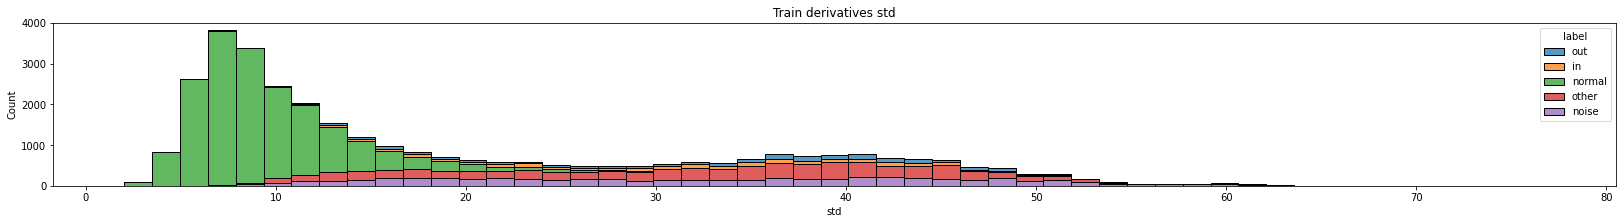

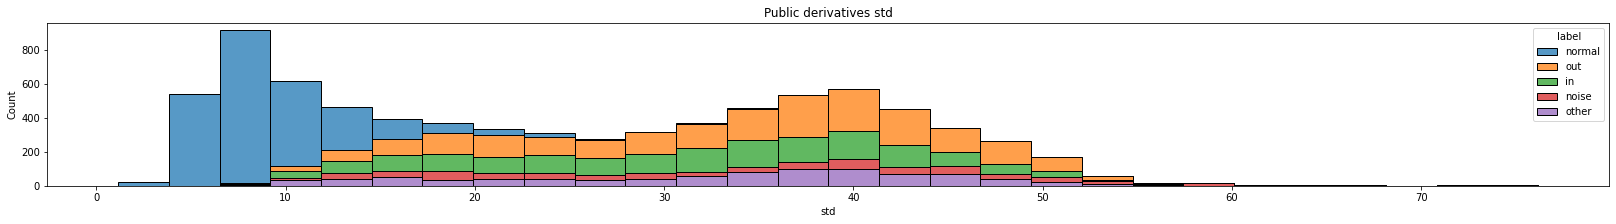

In [ ]:
plt.figure(figsize=fs)
sns.histplot(data=derivatives_aihub, x='std', hue='label', multiple='stack')
plt.title('Aihub derivatives std')
plt.show()

plt.figure(figsize=fs)
sns.histplot(data=derivatives_train, x='std', hue='label', multiple='stack')
plt.title('Train derivatives std')
plt.show()

plt.figure(figsize=fs)
sns.histplot(data=derivatives_public, x='std', hue='label', multiple='stack')
plt.title('Public derivatives std')
plt.show()

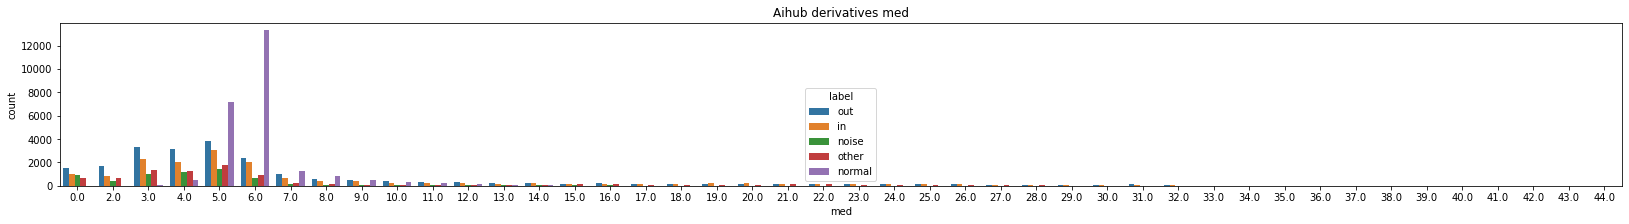

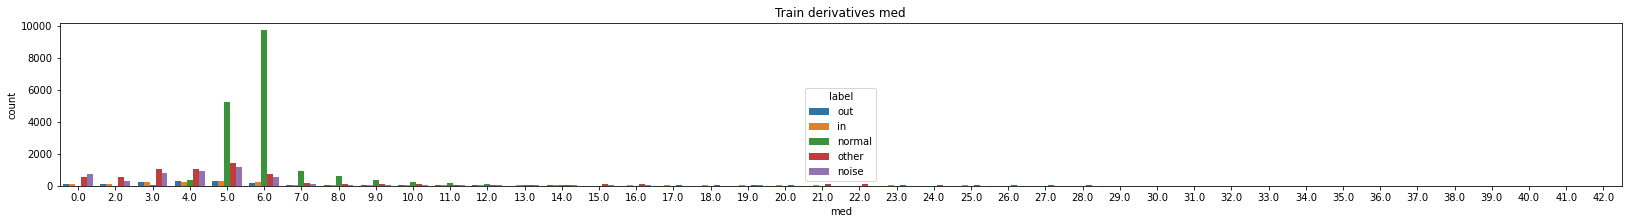

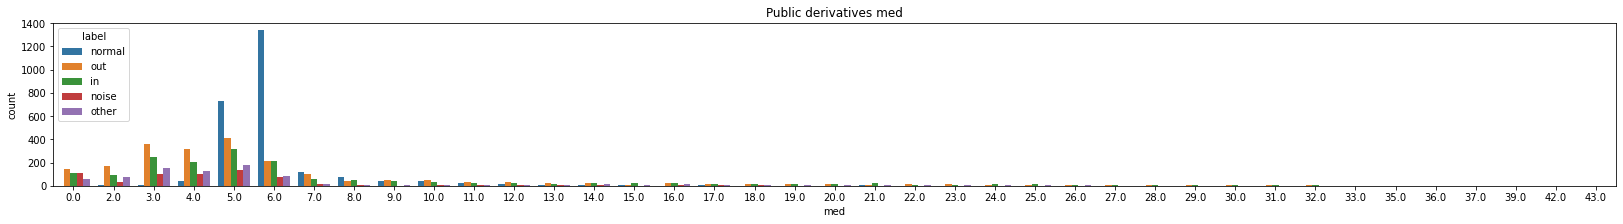

In [ ]:
plt.figure(figsize=fs)
sns.countplot(data=derivatives_aihub, x='med', hue='label')
plt.title('Aihub derivatives med')
plt.show()

plt.figure(figsize=fs)
sns.countplot(data=derivatives_train, x='med', hue='label')
plt.title('Train derivatives med')
plt.show()

plt.figure(figsize=fs)
sns.countplot(data=derivatives_public, x='med', hue='label')
plt.title('Public derivatives med')
plt.show()

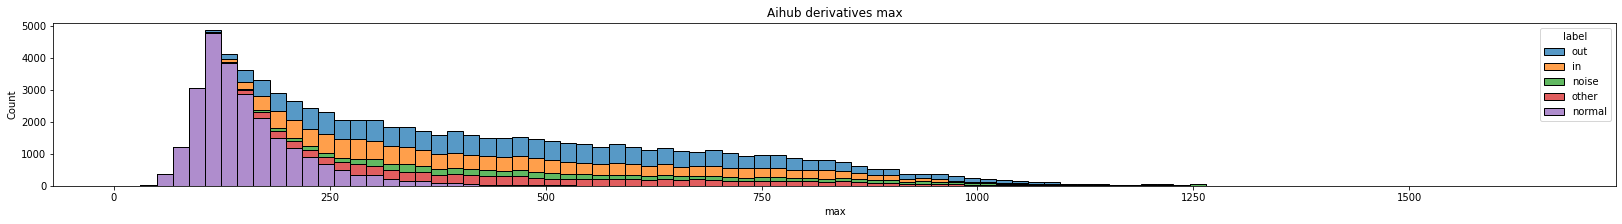

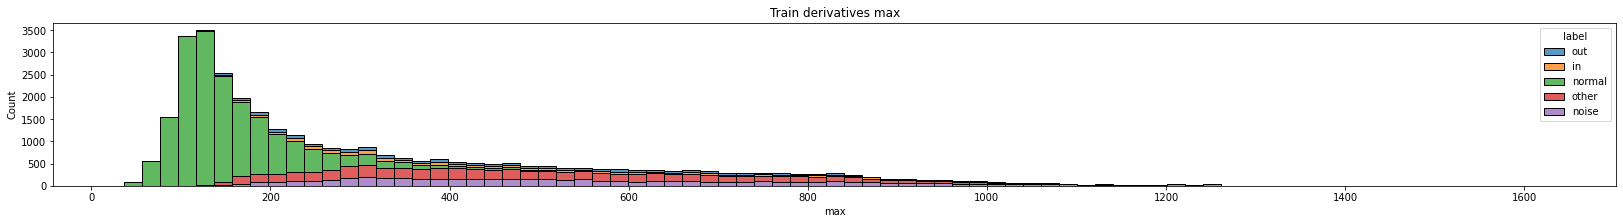

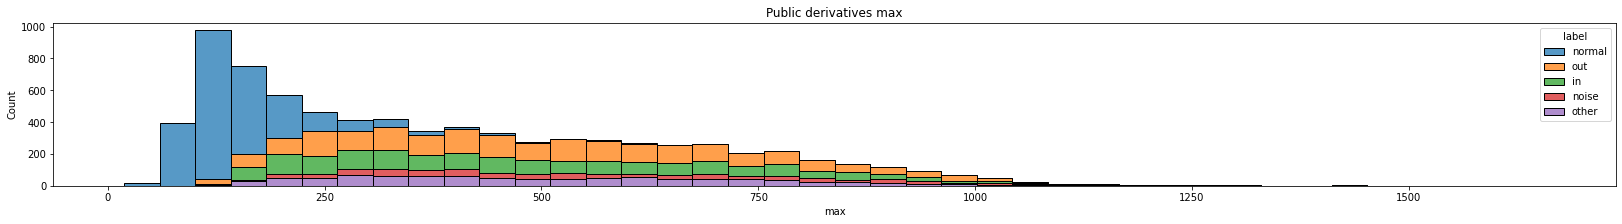

In [ ]:
plt.figure(figsize=fs)
sns.histplot(data=derivatives_aihub, x='max', hue='label', multiple='stack')
plt.title('Aihub derivatives max')
plt.show()

plt.figure(figsize=fs)
sns.histplot(data=derivatives_train, x='max', hue='label', multiple='stack')
plt.title('Train derivatives max')
plt.show()

plt.figure(figsize=fs)
sns.histplot(data=derivatives_public, x='max', hue='label', multiple='stack')
plt.title('Public derivatives max')
plt.show()

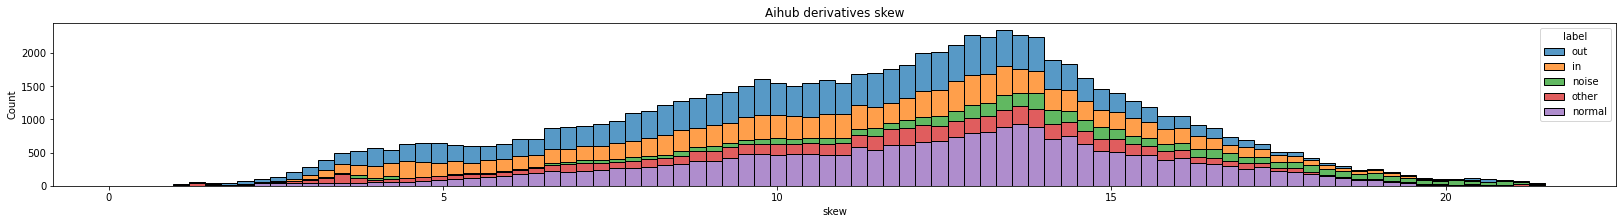

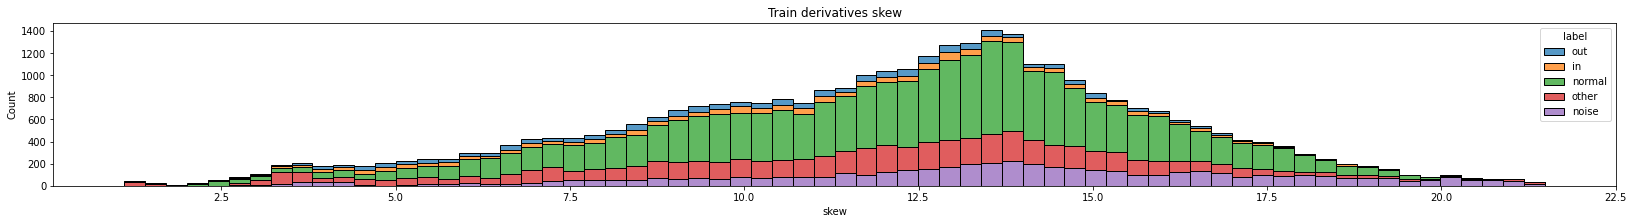

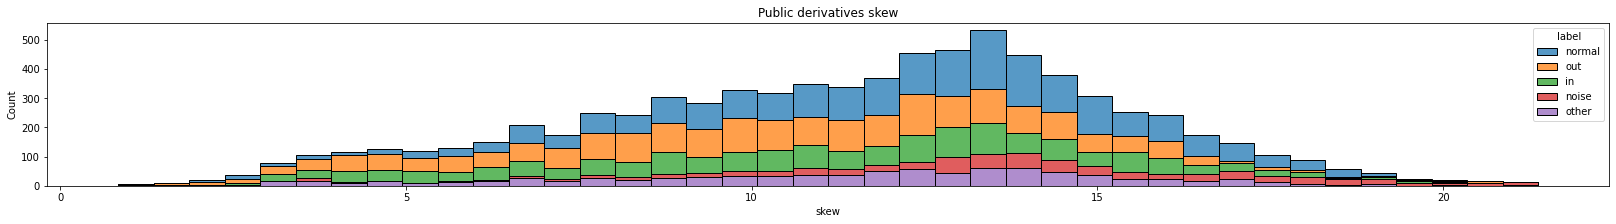

In [ ]:
plt.figure(figsize=fs)
sns.histplot(data=derivatives_aihub, x='skew', hue='label', multiple='stack')
plt.title('Aihub derivatives skew')
plt.show()

plt.figure(figsize=fs)
sns.histplot(data=derivatives_train, x='skew', hue='label', multiple='stack')
plt.title('Train derivatives skew')
plt.show()

plt.figure(figsize=fs)
sns.histplot(data=derivatives_public, x='skew', hue='label', multiple='stack')
plt.title('Public derivatives skew')
plt.show()

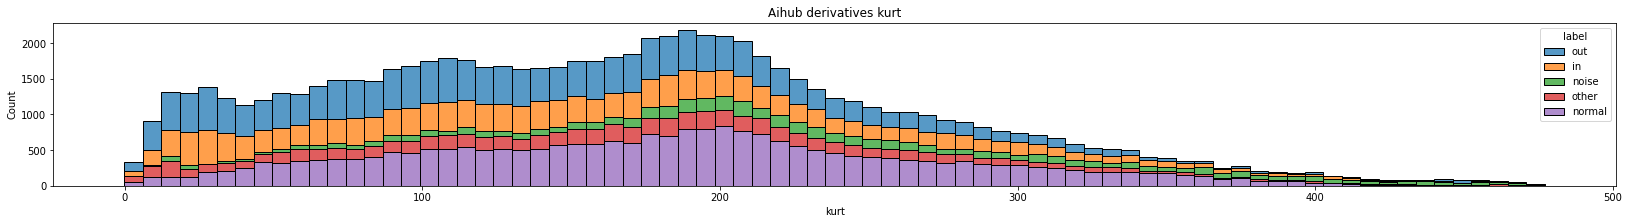

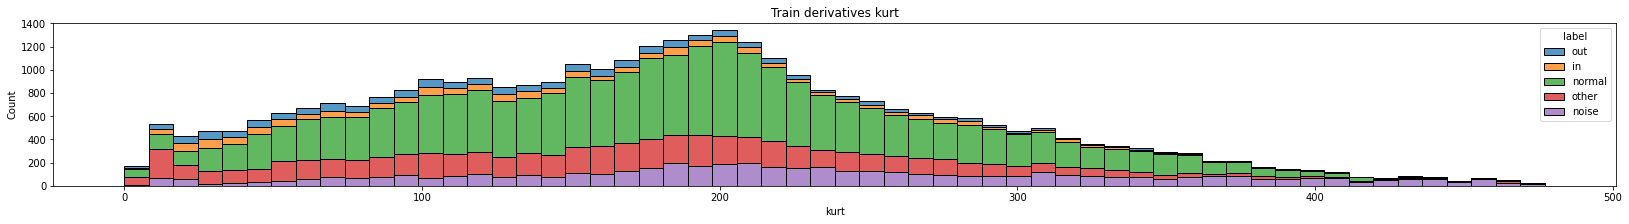

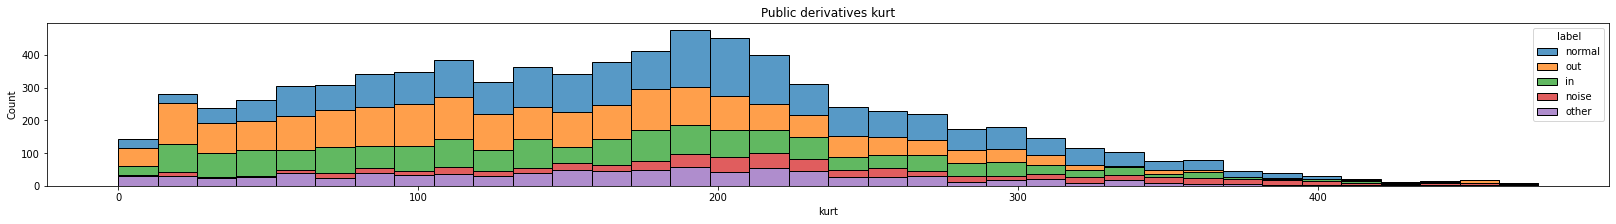

In [ ]:
plt.figure(figsize=fs)
sns.histplot(data=derivatives_aihub, x='kurt', hue='label', multiple='stack')
plt.title('Aihub derivatives kurt')
plt.show()

plt.figure(figsize=fs)
sns.histplot(data=derivatives_train, x='kurt', hue='label', multiple='stack')
plt.title('Train derivatives kurt')
plt.show()

plt.figure(figsize=fs)
sns.histplot(data=derivatives_public, x='kurt', hue='label', multiple='stack')
plt.title('Public derivatives kurt')
plt.show()

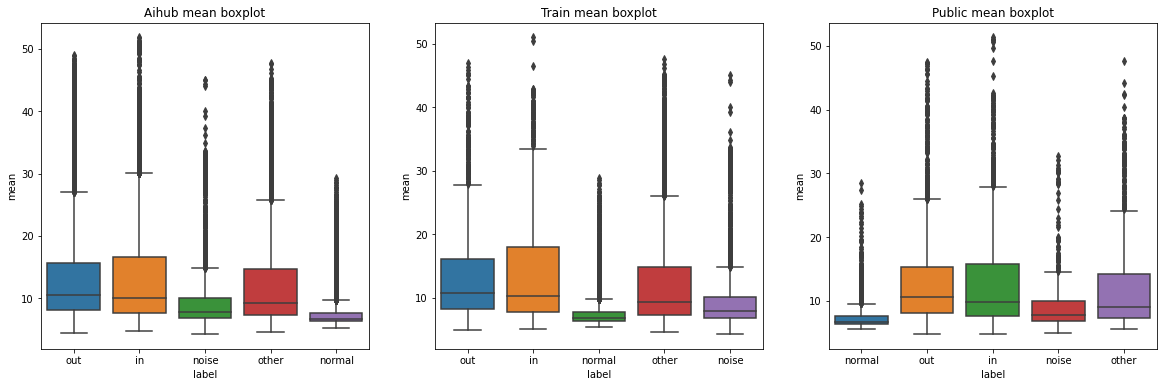

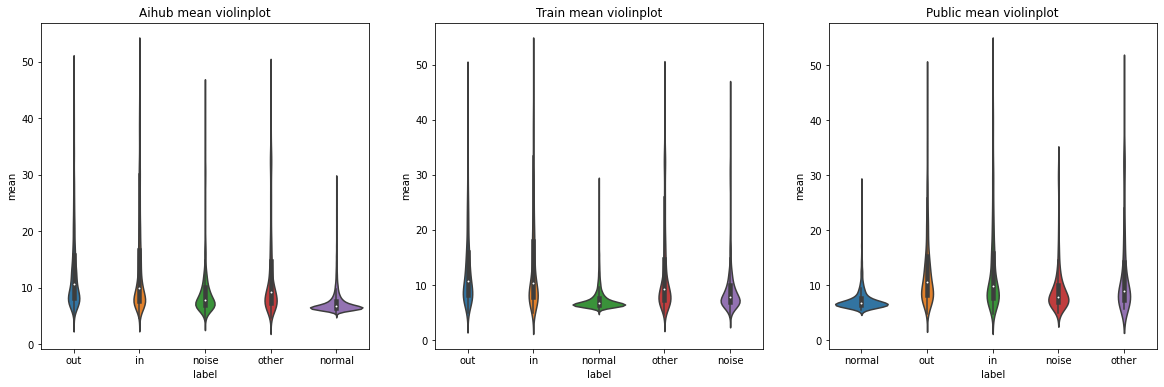

In [ ]:
fs = (20, 6)
fig = plt.figure(figsize=fs)
fig.add_subplot(131)
sns.boxplot(data=derivatives_aihub, x='label', y='mean')
plt.title('Aihub mean boxplot')
fig.add_subplot(132)
sns.boxplot(data=derivatives_train, x='label', y='mean')
plt.title('Train mean boxplot')
fig.add_subplot(133)
sns.boxplot(data=derivatives_public, x='label', y='mean')
plt.title('Public mean boxplot')
plt.show()

fig = plt.figure(figsize=fs)
fig.add_subplot(131)
sns.violinplot(data=derivatives_aihub, x='label', y='mean')
plt.title('Aihub mean violinplot')
fig.add_subplot(132)
sns.violinplot(data=derivatives_train, x='label', y='mean')
plt.title('Train mean violinplot')
fig.add_subplot(133)
sns.violinplot(data=derivatives_public, x='label', y='mean')
plt.title('Public mean violinplot')
plt.show()

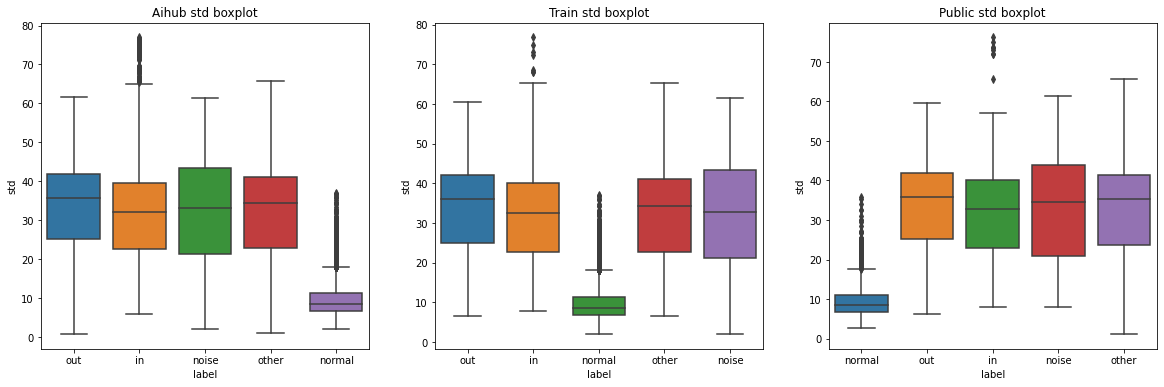

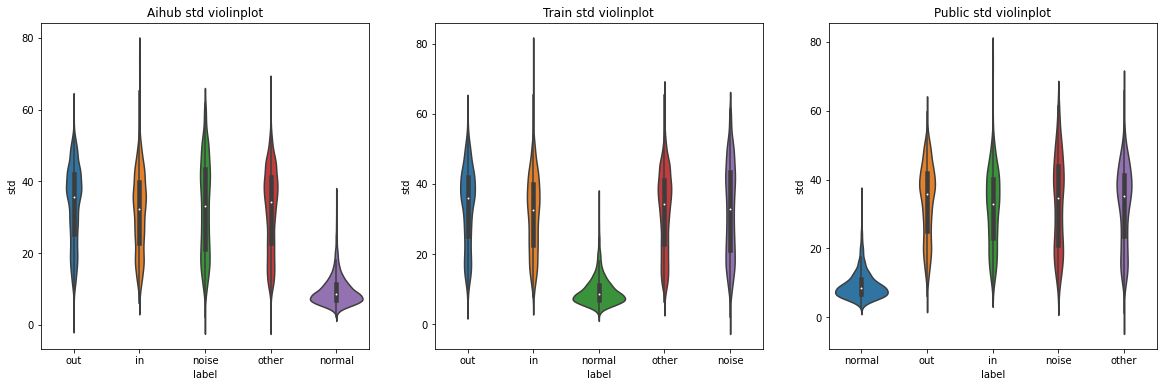

In [ ]:
fig = plt.figure(figsize=fs)
fig.add_subplot(131)
sns.boxplot(data=derivatives_aihub, x='label', y='std')
plt.title('Aihub std boxplot')
fig.add_subplot(132)
sns.boxplot(data=derivatives_train, x='label', y='std')
plt.title('Train std boxplot')
fig.add_subplot(133)
sns.boxplot(data=derivatives_public, x='label', y='std')
plt.title('Public std boxplot')
plt.show()

fig = plt.figure(figsize=fs)
fig.add_subplot(131)
sns.violinplot(data=derivatives_aihub, x='label', y='std')
plt.title('Aihub std violinplot')
fig.add_subplot(132)
sns.violinplot(data=derivatives_train, x='label', y='std')
plt.title('Train std violinplot')
fig.add_subplot(133)
sns.violinplot(data=derivatives_public, x='label', y='std')
plt.title('Public std violinplot')
plt.show()

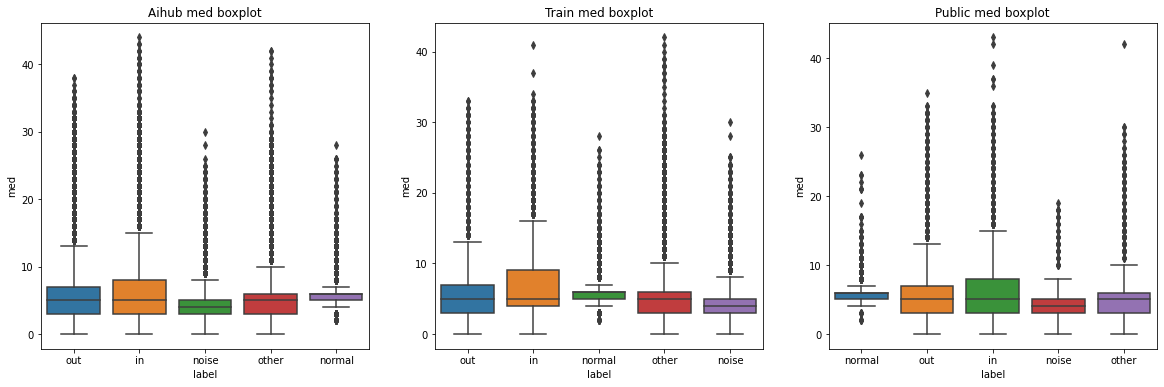

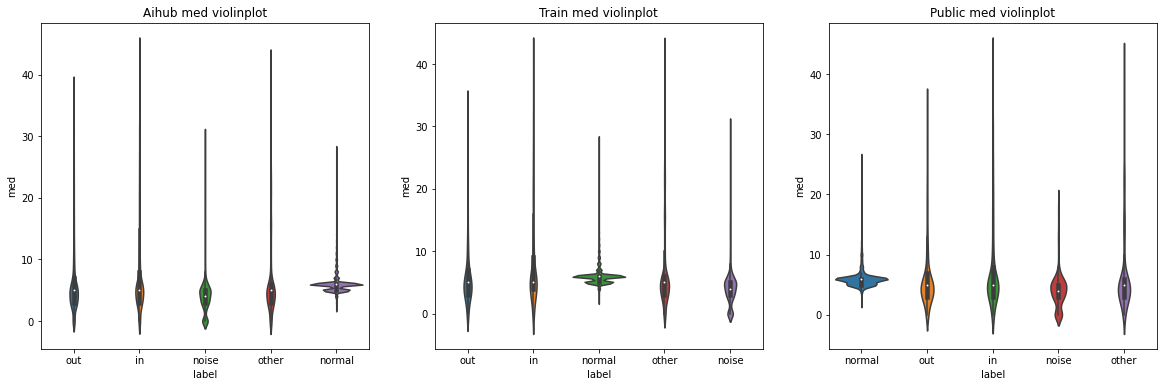

In [ ]:
fig = plt.figure(figsize=fs)
fig.add_subplot(131)
sns.boxplot(data=derivatives_aihub, x='label', y='med')
plt.title('Aihub med boxplot')
fig.add_subplot(132)
sns.boxplot(data=derivatives_train, x='label', y='med')
plt.title('Train med boxplot')
fig.add_subplot(133)
sns.boxplot(data=derivatives_public, x='label', y='med')
plt.title('Public med boxplot')
plt.show()

fig = plt.figure(figsize=fs)
fig.add_subplot(131)
sns.violinplot(data=derivatives_aihub, x='label', y='med')
plt.title('Aihub med violinplot')
fig.add_subplot(132)
sns.violinplot(data=derivatives_train, x='label', y='med')
plt.title('Train med violinplot')
fig.add_subplot(133)
sns.violinplot(data=derivatives_public, x='label', y='med')
plt.title('Public med violinplot')
plt.show()

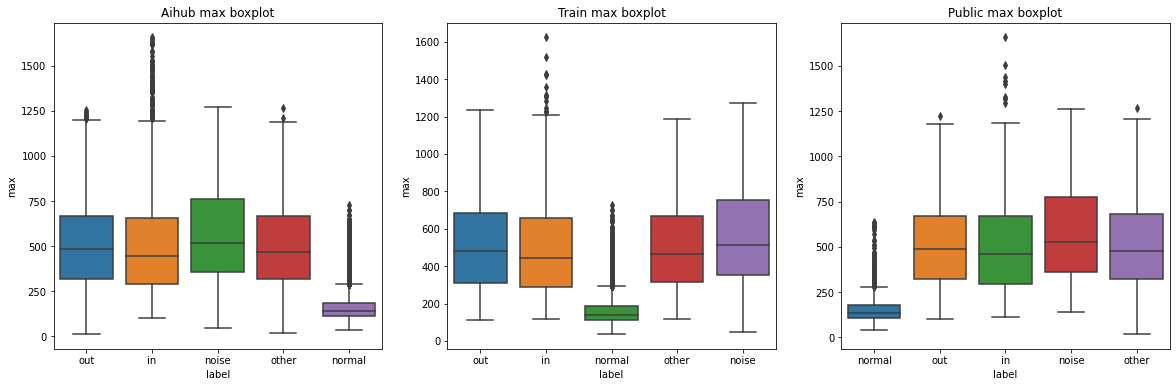

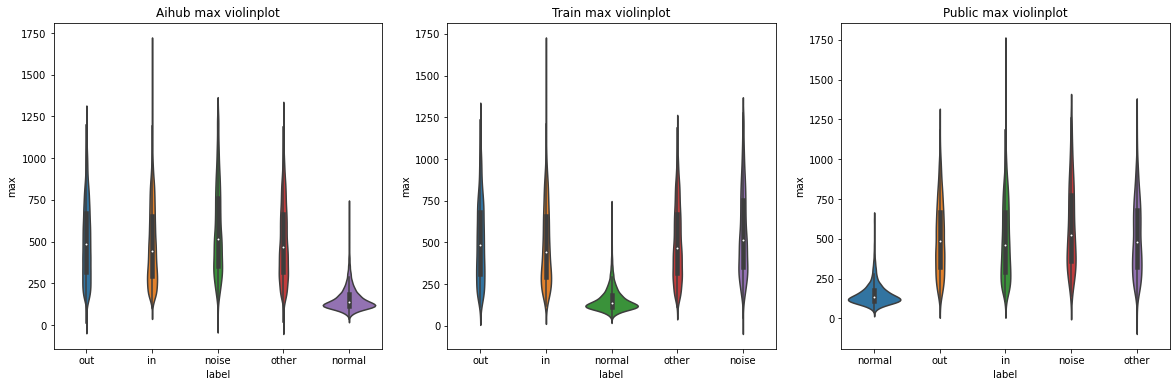

In [ ]:
fig = plt.figure(figsize=fs)
fig.add_subplot(131)
sns.boxplot(data=derivatives_aihub, x='label', y='max')
plt.title('Aihub max boxplot')
fig.add_subplot(132)
sns.boxplot(data=derivatives_train, x='label', y='max')
plt.title('Train max boxplot')
fig.add_subplot(133)
sns.boxplot(data=derivatives_public, x='label', y='max')
plt.title('Public max boxplot')
plt.show()

fig = plt.figure(figsize=fs)
fig.add_subplot(131)
sns.violinplot(data=derivatives_aihub, x='label', y='max')
plt.title('Aihub max violinplot')
fig.add_subplot(132)
sns.violinplot(data=derivatives_train, x='label', y='max')
plt.title('Train max violinplot')
fig.add_subplot(133)
sns.violinplot(data=derivatives_public, x='label', y='max')
plt.title('Public max violinplot')
plt.show()

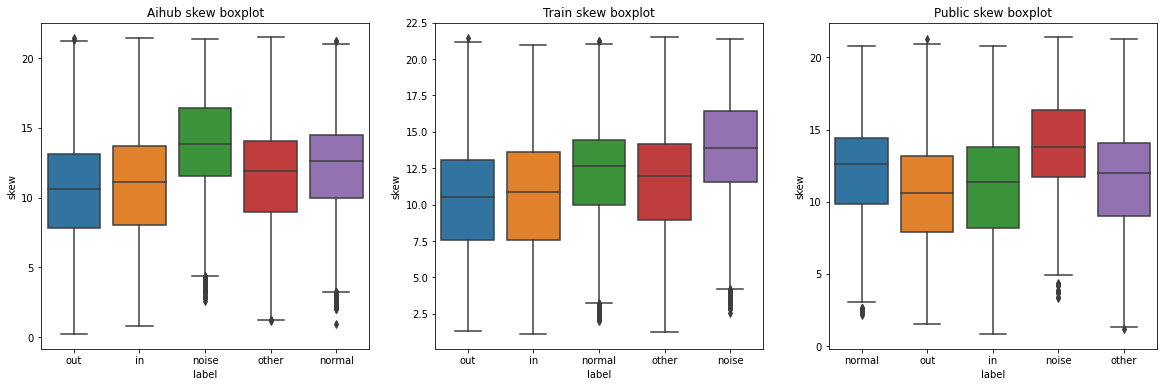

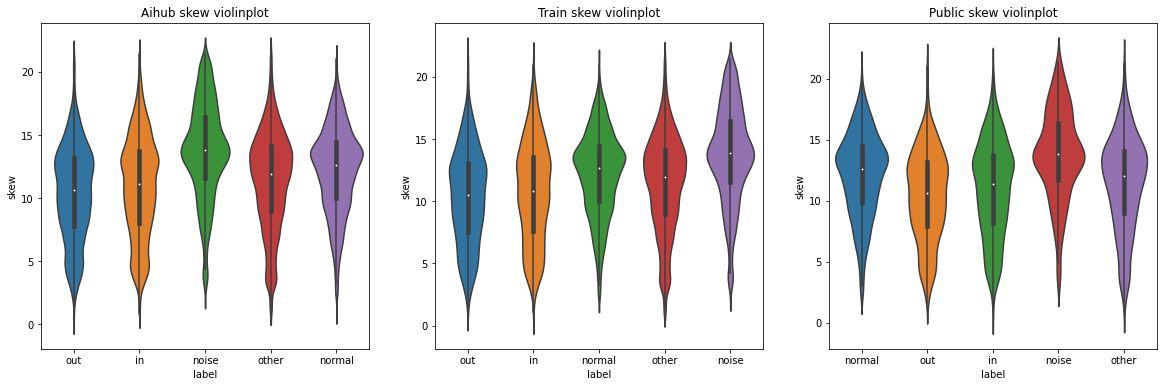

In [ ]:
fig = plt.figure(figsize=fs)
fig.add_subplot(131)
sns.boxplot(data=derivatives_aihub, x='label', y='skew')
plt.title('Aihub skew boxplot')
fig.add_subplot(132)
sns.boxplot(data=derivatives_train, x='label', y='skew')
plt.title('Train skew boxplot')
fig.add_subplot(133)
sns.boxplot(data=derivatives_public, x='label', y='skew')
plt.title('Public skew boxplot')
plt.show()

fig = plt.figure(figsize=fs)
fig.add_subplot(131)
sns.violinplot(data=derivatives_aihub, x='label', y='skew')
plt.title('Aihub skew violinplot')
fig.add_subplot(132)
sns.violinplot(data=derivatives_train, x='label', y='skew')
plt.title('Train skew violinplot')
fig.add_subplot(133)
sns.violinplot(data=derivatives_public, x='label', y='skew')
plt.title('Public skew violinplot')
plt.show()

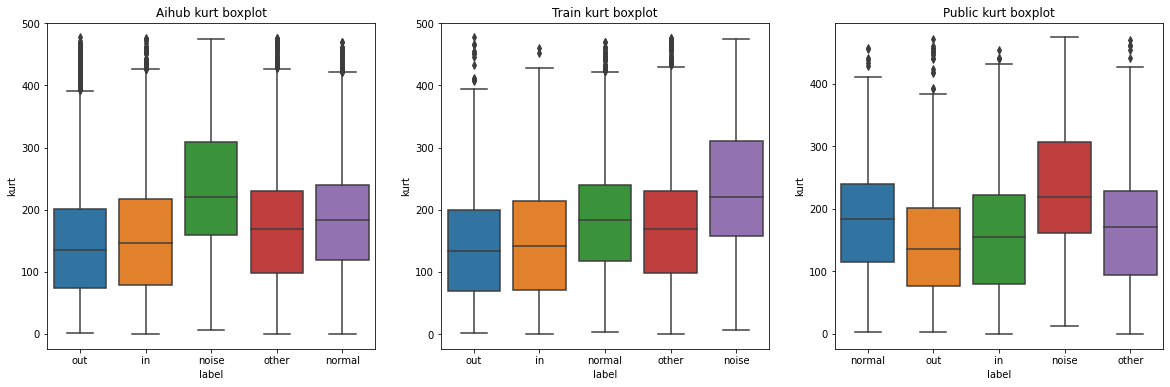

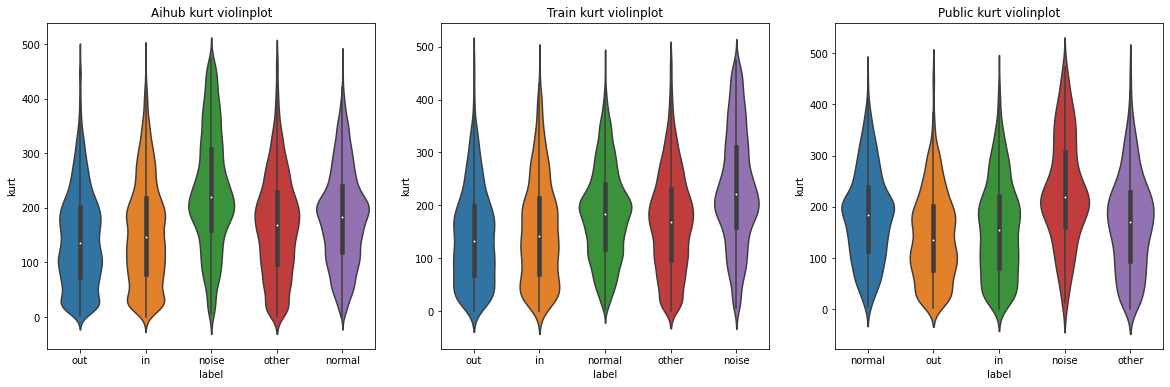

In [ ]:
fig = plt.figure(figsize=fs)
fig.add_subplot(131)
sns.boxplot(data=derivatives_aihub, x='label', y='kurt')
plt.title('Aihub kurt boxplot')
fig.add_subplot(132)
sns.boxplot(data=derivatives_train, x='label', y='kurt')
plt.title('Train kurt boxplot')
fig.add_subplot(133)
sns.boxplot(data=derivatives_public, x='label', y='kurt')
plt.title('Public kurt boxplot')
plt.show()

fig = plt.figure(figsize=fs)
fig.add_subplot(131)
sns.violinplot(data=derivatives_aihub, x='label', y='kurt')
plt.title('Aihub kurt violinplot')
fig.add_subplot(132)
sns.violinplot(data=derivatives_train, x='label', y='kurt')
plt.title('Train kurt violinplot')
fig.add_subplot(133)
sns.violinplot(data=derivatives_public, x='label', y='kurt')
plt.title('Public kurt violinplot')
plt.show()

## inverse fourier transform

In [ ]:
train_audio, train_spectral_label = inverse_spectral_density(train, cols, 'leaktype')
aihub_audio, aihub_spectral_label = inverse_spectral_density(aihub, cols, 'leaktype')
public_audio, public_spectral_label = inverse_spectral_density(public, cols, 'leaktype')

print(train_audio.shape, train_spectral_label.shape)
print(aihub_audio.shape, aihub_spectral_label.shape)
print(public_audio.shape, public_spectral_label.shape)

(33600, 512) (33600,)
(78204, 512) (78204,)
(7820, 512) (7820,)


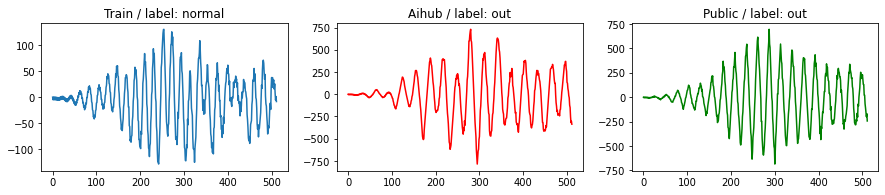

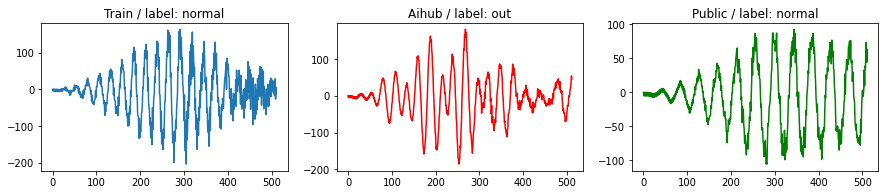

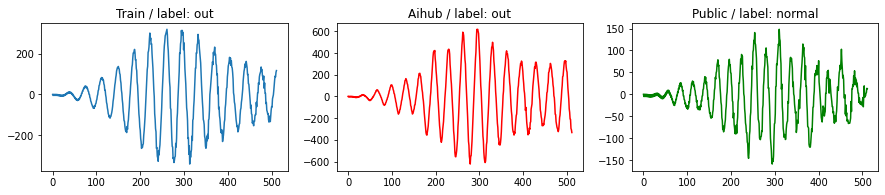

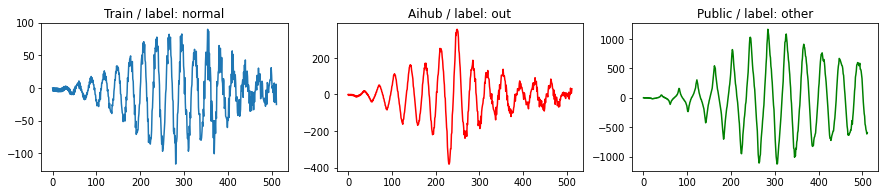

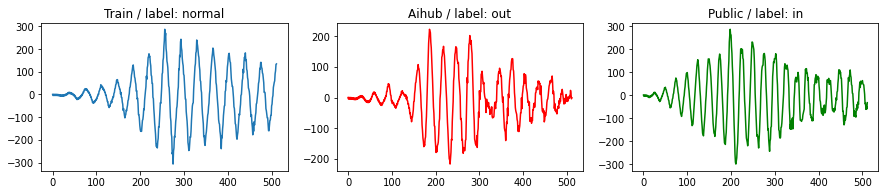

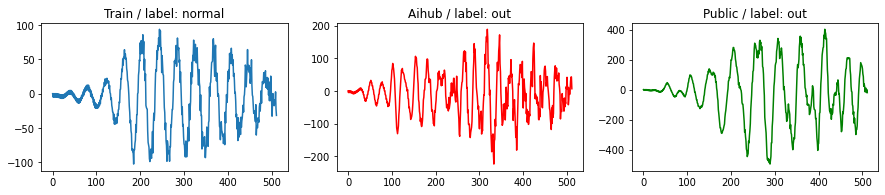

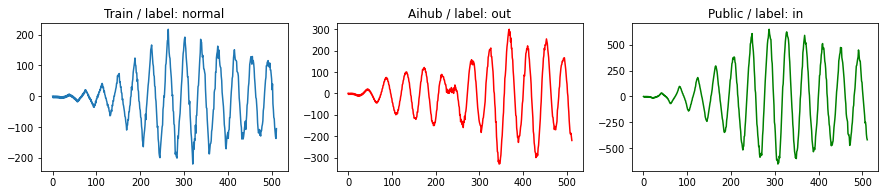

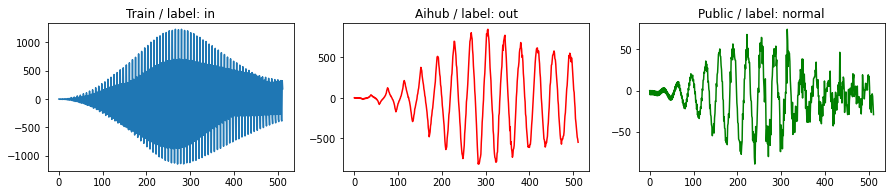

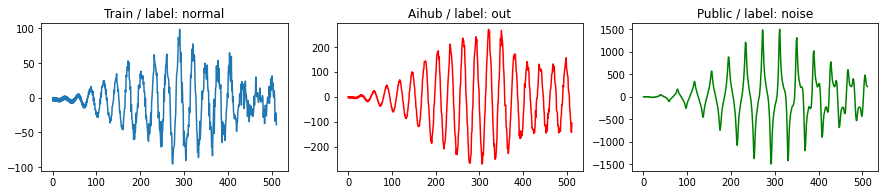

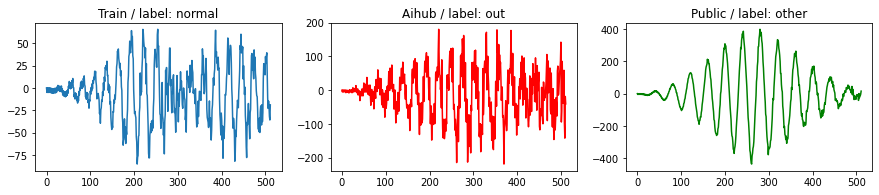

In [ ]:
for i in np.random.randint(low=0, high=7820, size=10):
    fig = plt.figure(figsize=(15, 6))

    fig.add_subplot(231)
    plt.plot(train_audio.values[i])
    plt.title(f'Train / label: {train_spectral_label[i]}')

    fig.add_subplot(232)
    plt.plot(aihub_audio.values[i], 'r')
    plt.title(f'Aihub / label: {aihub_spectral_label[i]}')

    fig.add_subplot(233)
    plt.plot(public_audio.values[i], 'g')
    plt.title(f'Public / label: {public_spectral_label[i]}')

    plt.show()

## Constant-Q

In [ ]:
idx = 30

train_cqt = librosa.amplitude_to_db(librosa.cqt(np.abs(train_audio.values[idx])), ref=np.max)
aihub_cqt = librosa.amplitude_to_db(librosa.cqt(np.abs(aihub_audio.values[idx])), ref=np.max)
public_cqt = librosa.amplitude_to_db(librosa.cqt(np.abs(public_audio.values[idx])), ref=np.max)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=256 is too small for input signal of length=128
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=256 is too small for input signal of length=64
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=256 is too small for input signal of length=32
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=256 is too small for input signal of length=16
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=256 is too small for input signal of length=8
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:1642: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs

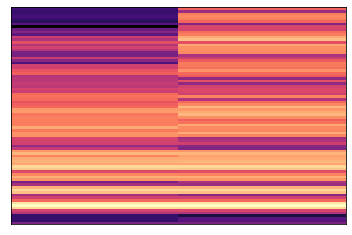

In [ ]:
librosa.display.specshow(train_cqt)

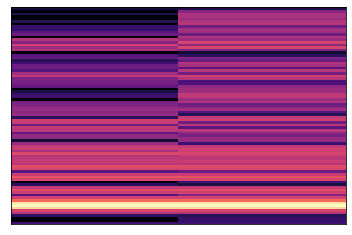

In [ ]:
librosa.display.specshow(aihub_cqt)

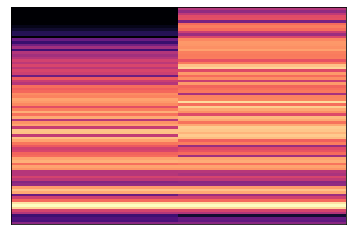

In [ ]:
librosa.display.specshow(public_cqt)

## MFCC

In [ ]:
idx = 30

train_mfcc = librosa.amplitude_to_db(librosa.feature.mfcc(np.abs(train_audio.values[idx])), ref=np.max)
aihub_mfcc = librosa.amplitude_to_db(librosa.feature.mfcc(np.abs(aihub_audio.values[idx])), ref=np.max)
public_mfcc = librosa.amplitude_to_db(librosa.feature.mfcc(np.abs(public_audio.values[idx])), ref=np.max)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=512
  n_fft, y.shape[-1]


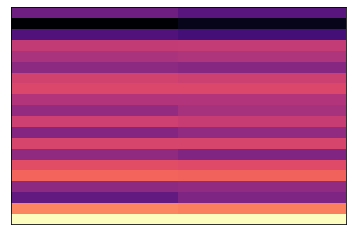

In [ ]:
librosa.display.specshow(train_mfcc)

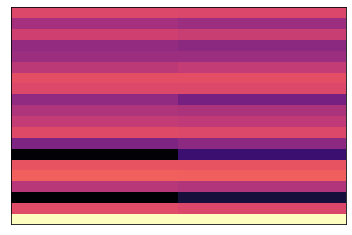

In [ ]:
librosa.display.specshow(aihub_mfcc)

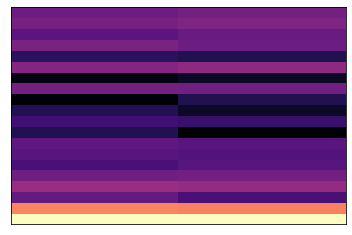

In [ ]:
librosa.display.specshow(public_mfcc)